## Modelling serological testing using the `Spp` class

In the present notebook, we use the `pyross.deterministic.Spp` class and specify a finite-ressource transition to model serological testing

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model with antibody testing

Below you will find the model-specification dictionary for the SIR model with a finite-ressource transition:

In [2]:
model_spec = {
    "classes" : ["S", "I", "R", "T+", "T-"],

    "S" : {
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ]
    },
    
     "R" : {
        "linear" : [ ["I", "gamma"] ]
    },
    
     "T+" : {
        "finite-resource" :  [ [ "S", "tau", "pi", "falsepos"], ["I", "tau", "pi", "falsepos"], ["R", "tau", "pi", "truepos"] ]
     },
    
    "T-" : {
        "finite-resource" :  [ [ "S", "tau", "pi", "trueneg"], ["I", "tau", "pi", "trueneg"], ["R", "tau", "pi", "falseneg"] ]
     }
}



This corresponds to

$$
\begin{aligned}
\dot{S}_i & = k - \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i \\
\dot{I}_i & = \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \gamma I_i \\
\dot{R}_i & = \gamma I_i \\
\dot{T}_i & = \frac{\tau \pi_i \phi_{\mathrm{false},i}^+}{\mathcal{N}}S_i + \frac{\tau \pi_i \phi_{\mathrm{false},i}^+}{\mathcal{N}}I_i + \frac{\tau \pi_i \phi_{\mathrm{true},i}^+}{\mathcal{N}}R_i
\end{aligned}
$$
with
$$
\mathcal{N} = \sum_i (\pi_i S_i + \pi_i I_i + \pi_i R_i).
$$


Next, we define the parameter values:

In [43]:
falsepos=0.1
truepos=0.99

parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'tau' : 10,
    'pi' : 1,
    'falsepos' : falsepos,
    'trueneg'  : 1 - falsepos,
    'truepos' : truepos,
    'falseneg' : 1 - truepos
}

The initial conditions can be defined in either of two ways. They can either be defined using a dictionary, where for each model class we have a corresponding 1D array of length $M$ (where $M$ is the number of age-groups), or a numpy array. The numpy array must have dimensions $M \times (d-1)$, where $d$ is the number of model classes (so 3 for SIR, for example).

If the initial conditions are provided as a dictionary, we are free to leave out one of the classes. In which case the initial conditions of the left out class will be inferred from the others.

In [55]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    999, 999, 999, # S
    1,   1,    1,    # I
    0,   0,    0,    # R
    0,   0,    0,    # T+
    0,   0,    0     # T-
])


CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# Tests performed per day
def testRate(t):
    if t>100 and t<120:
        return 10
    else:
        return 0

def parameter_mapping(params, t):
    output = params.copy()
    output['tau']=testRate(t)
    return output

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.deterministic.Spp(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

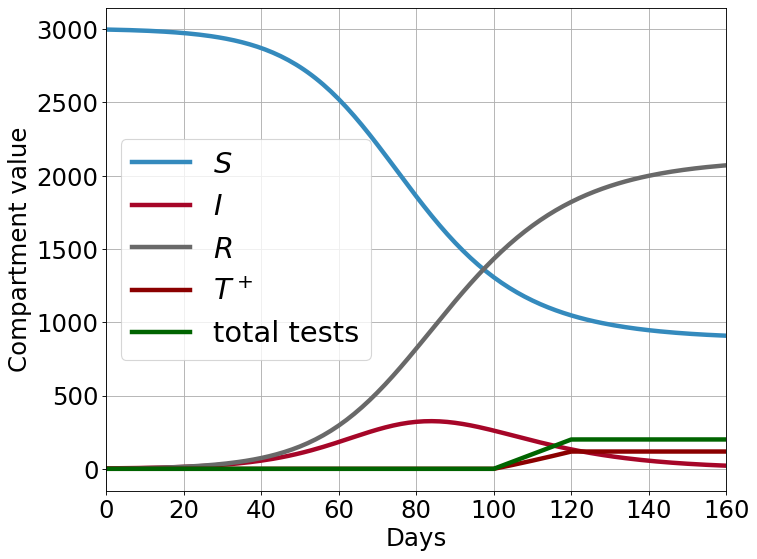

In [56]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
Tp = np.sum(model.model_class_data('T+', data), axis=1)
Tm = np.sum(model.model_class_data('T-', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)


plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)


plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)


plt.plot(t, Tp, '-', color="darkred", label='$T^+$', lw=4)
plt.plot(t, Tm+Tp, '-', color="darkgreen", label='total tests', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [57]:
Tp[-1]/(Tm[-1]+Tp[-1])

0.5889923669310737

### The SIR model with antibody testing and PCR testing

Below you will find the model-specification dictionary for the SIR model with two different finite-ressource transitions:

In [38]:
model_spec = {
    "classes" : ["S", "I", "R", "T", "Q"],

    "S" : {
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ],
        "finite-resource" : [ ["I", "-tauPCR", "piPCR_s", "trueposPCR"] ]
    },
    
     "R" : {
        "linear" : [ ["I", "gamma"] ]
    },
    
     "T" : {
        "finite-resource" :  [ [ "S", "tauAB", "piAB", "falseposAB"], ["I", "tauAB", "piAB", "falseposAB"], ["R", "tauAB", "piAB", "trueposAB"] ]
     },
    
    "Q" : {
        "finite-resource" : [ [ "S", "tauPCR", "piPCR_a", "falseposPCR"], ["I", "tauPCR", "piPCR_s", "trueposPCR"], ["R", "tauPCR", "piPCR_a", "falseposPCR"] ]
    }
}

parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'tauAB' : 10,
    'tauPCR' : 5,
    'piAB' : 1,
    'piPCR_a' : 0.1,
    'piPCR_s' : 1,
    'falseposAB' : 0.1,
    'trueposAB' : 0.99,
    'falseposPCR' : 0,
    'trueposPCR' : 1
}